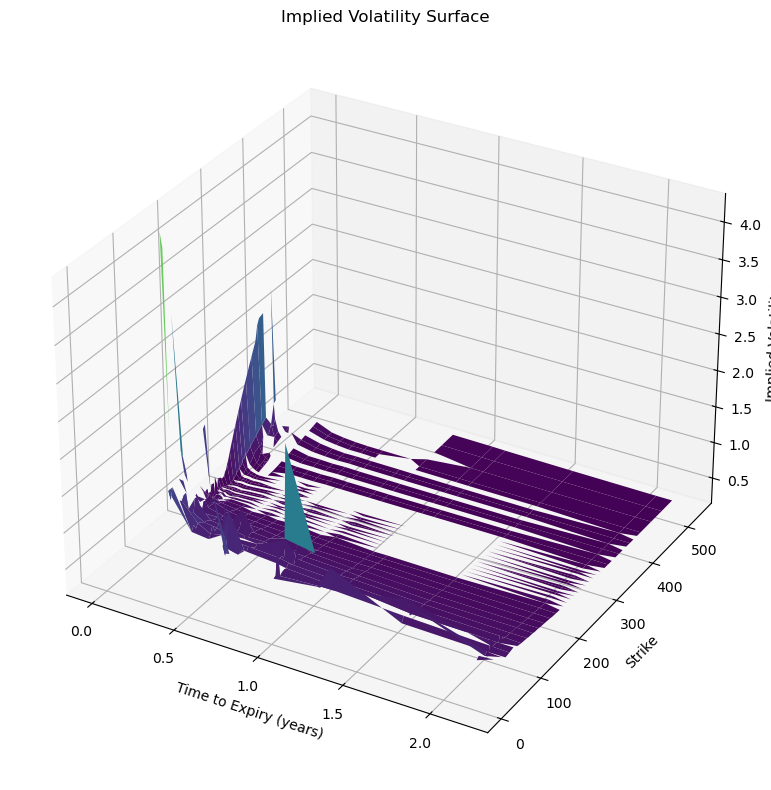

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


# -----------------------------------------
# Black-Scholes pricing (simple version)
# -----------------------------------------
def bs_price(S, K, T, r, sigma, option_type="call"):
    if T <= 0:
        return max(0, (S - K) if option_type == "call" else (K - S))

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


# -----------------------------------------
# Implied Volatility (Brent root search)
# -----------------------------------------
def implied_vol(price, S, K, T, r, option_type):
    if price <= 0:
        return np.nan

    def f(sigma):
        return bs_price(S, K, T, r, sigma, option_type) - price

    try:
        # Search between very small vol and 500% vol
        return brentq(f, 1e-6, 5)
    except:
        return np.nan


# -----------------------------------------
# Fetch chain and compute IVs (simple)
# -----------------------------------------
def get_all_option_iv(symbol, r=0.03):
    ticker = yf.Ticker(symbol)

    # Get current underlying price
    S = ticker.history(period="1d")["Close"].iloc[-1]

    all_rows = []

    for exp in ticker.options:
        chain = ticker.option_chain(exp)

        # Days-to-expiry
        exp_date = dt.datetime.strptime(exp, "%Y-%m-%d").date()
        T = (exp_date - dt.date.today()).days / 365

        # Process Calls + Puts
        for opt_type, df in [("call", chain.calls), ("put", chain.puts)]:
            for _, row in df.iterrows():
                K = float(row["strike"])
                bid = float(row.get("bid", 0))
                ask = float(row.get("ask", 0))

                # Use mid-price
                if bid > 0 and ask > 0:
                    price = (bid + ask) / 2
                else:
                    price = float(row.get("lastPrice", 0))

                iv = implied_vol(price, S, K, T, r, opt_type)

                all_rows.append({
                    "symbol": symbol,
                    "expiration": exp,
                    "type": opt_type,
                    "strike": K,
                    "price": price,
                    "iv": iv,
                    "iv_%": iv * 100 if iv == iv else 0
                })

    return pd.DataFrame(all_rows)

def rotate(angle):
    # ax.view_init(elev, azim)
    ax.view_init(30, angle) # Constant elevation, changing azimuth
# -----------------------------------------
# Run example
# -----------------------------------------

def plot_iv_surface(df):
    """
    df must contain:
        'strike'  (float)
        'expiration' (string YYYY-MM-DD)
        'iv' (float implied vol)
    """

    # Convert expiration dates to numeric time-to-expiry (in years)
    df = df.copy()
    df["expiration"] = pd.to_datetime(df["expiration"])
    today = pd.Timestamp.today()
    df["T"] = (df["expiration"] - today).dt.days / 365

    # Drop rows with NaN IV
    df = df.dropna(subset=["iv"])

    # Pivot into grid (strikes × maturities)
    surface = df.pivot_table(
        index="strike", 
        columns="T", 
        values="iv"
    )

    X = surface.columns.values      # maturities
    Y = surface.index.values        # strikes
    X_grid, Y_grid = np.meshgrid(X, Y)
    Z_grid = surface.values         # IVs

    # --- Plot ---
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_surface(
        X_grid,
        Y_grid,
        Z_grid,
        linewidth=0,
        antialiased=True,
        cmap="viridis"
    )

    ax.set_xlabel("Time to Expiry (years)")
    ax.set_ylabel("Strike")
    ax.set_zlabel("Implied Volatility")

    ax.set_title("Implied Volatility Surface")
    plt.tight_layout()
    plt.show()



def main():
    df = get_all_option_iv("AAPL")

    df_calls = df[(df['type'] == 'call')]
    df_puts = df[(df['type'] == 'put')]

    df_iv = df_calls[['strike', 'expiration', 'iv']]
    df_iv.to_csv("/Users/home/Desktop/iv_surface.csv", index=False)
    plot_iv_surface(df_iv)

   # print(df.head())
    #df.to_csv("/Users/home/Desktop/option_chain_iv.csv", index=False)
    #print("Saved option_chain_iv.csv")


main()
